<a href="https://colab.research.google.com/github/locdacknownothing/SportImageClassification/blob/main/Group_nl_sport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. General Information

*   Members:
  1.   Truong Nguyen Khoi Nguyen - 2010468
  2.   Ta Le Dac Loc - 2010396
* Datasets:
  *   [Sports-Classification-Dataset](https://www.kaggle.com/datasets/ponrajsubramaniian/sportclassificationdataset)
* Backbone:
  - [*INCEPTIONRESNETV2*](https://arxiv.org/abs/1602.07261v2)

  

#2. Data Preparation

## 2.1. Download Datasets

In [ ]:
 !pip install -q kaggle

In [ ]:
# Create a kaggle.json file instead of upload from local
f = open("kaggle.json", "w")
f.write("""{"username":"trngnguynkhinguyn","key":"6897bfd7e35db9d4202ea7374ed5a457"}""")
f.close()

In [ ]:
# kaggle.json expect tp=o be put in the ~/.kaggle folder
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

# Set the permission 
! chmod 600 ~/.kaggle/kaggle.json

# Download the dataset use the API we metion above
! kaggle datasets download -d ponrajsubramaniian/sportclassificationdataset

# Download trained models for comparation
! kaggle datasets download -d trngnguynkhinguyn/trained-models

 97% 566M/583M [00:02<00:00, 193MB/s]
100% 583M/583M [00:03<00:00, 204MB/s]
 98% 618M/632M [00:11<00:00, 75.1MB/s]
100% 632M/632M [00:11<00:00, 58.0MB/s]


In [ ]:
# Create folder to store data
! mkdir sports
! unzip sportclassificationdataset.zip -d sports

# Create folder to store trained models
! mkdir trained_models
! unzip trained-models.zip -d trained_models

In [ ]:
path_to_data = './sports/Sports-Type-Classifier-master/data'

## 2.2. Import libraries

In [ ]:
# Basic
import os
import glob
import numpy as np
import pandas as pd

# Data Viz
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Tensorflow for machine learning
import tensorflow as tf
import tensorflow.keras.utils as utils
import tensorflow.keras.applications as app
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Dense, GlobalAvgPool2D as GAP, Dropout
from keras.models import load_model, Model
from keras.metrics import TopKCategoricalAccuracy
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping


# Classification models
from tensorflow.keras.applications import InceptionResNetV2, VGG16, ResNet50, NASNetLarge

# For deleting folder that not empty
import shutil

## 2.3. Exploring dataset


- Link: https://www.kaggle.com/datasets/ponrajsubramaniian/sportclassificationdataset/download?datasetVersionNumber=1

- This dataset contains the images of various sports in the of range of 500-700 for each category.

- Dataset has size of 612MB

### 2.3.1 Get list of class names

First we need to check how many class names in our dataset

Here we see that there is a folder which is not a class so we will delete it

In [ ]:
! rm -r ./sports/Sports-Type-Classifier-master/data/.ipynb_checkpoints

In [ ]:
class_names = list(filter(lambda f: os.path.isdir(os.path.join(path_to_data, f)), os.listdir(path_to_data)))
class_names = sorted(class_names)
num_classes = len(class_names)
print(f"Class Names: \n{class_names}")
print(f"Total Number of Classes : {num_classes}")

Class Names: 
['badminton', 'baseball', 'basketball', 'boxing', 'chess', 'cricket', 'fencing', 'football', 'formula1', 'gymnastics', 'hockey', 'ice_hockey', 'kabaddi', 'models', 'motogp', 'shooting', 'swimming', 'table_tennis', 'tennis', 'volleyball', 'weight_lifting', 'wrestling', 'wwe']
Total Number of Classes : 23


### 2.3.2. Remove not image files

We know that in our dataset have some file which is not a image, so we will clean it by the following way:
- First get all the link to all class folder
- Save all the link to the file that is not image (files that is not endswith .jpg, .png, .jpeg)

In [ ]:
# Get all the links to all the directories
class_dir = [os.path.join(path_to_data, dir) for dir in class_names]

# Get the link to the not image files
not_images = [os.path.join(images, image) for images in class_dir for image in os.listdir(images) if not (image.endswith('.jpg') or image.endswith('.JPG') or image.endswith('.png') or image.endswith('.PNG') or image.endswith('.jpeg') or image.endswith('.JPEG'))]

# Delete not image files in data (Image file is endswith: .png, .jpg, .jpeg)
for f in not_images:
  if os.path.isdir(f):
    shutil.rmtree(f, ignore_errors=True)
  else:
    os.remove(f)

### 2.3.3. Visualize the partition of dataset

In [ ]:
def viz_dataset(path, class_names):
  class_dis = [len(os.listdir(os.path.join(path, name))) for name in class_names]
  lk_dis = dict(zip(class_names, class_dis))
  print(f"Class Distribution : \n{lk_dis}")

  fig = px.pie(names=class_names, values=class_dis, width=600)
  fig.update_layout({"title":{'text':"Class Distribution","x":0.5}})
  fig.show()

viz_dataset(path_to_data, class_names)

Class Distribution : 
{'badminton': 928, 'baseball': 731, 'basketball': 490, 'boxing': 704, 'chess': 475, 'cricket': 665, 'fencing': 624, 'football': 784, 'formula1': 675, 'gymnastics': 711, 'hockey': 569, 'ice_hockey': 707, 'kabaddi': 452, 'models': 0, 'motogp': 668, 'shooting': 531, 'swimming': 683, 'table_tennis': 705, 'tennis': 714, 'volleyball': 703, 'weight_lifting': 572, 'wrestling': 601, 'wwe': 667}


Notice that the 'models' class has 0 image, so we will delete this class. Then delete this class in class_names

In [ ]:
os.rmdir(os.path.join(path_to_data, 'models'))
class_names.remove('models')

num_classes = num_classes - 1

Visualize the dataset again

In [ ]:
viz_dataset(path_to_data, class_names)

Class Distribution : 
{'badminton': 928, 'baseball': 731, 'basketball': 490, 'boxing': 704, 'chess': 475, 'cricket': 665, 'fencing': 624, 'football': 784, 'formula1': 675, 'gymnastics': 711, 'hockey': 569, 'ice_hockey': 707, 'kabaddi': 452, 'motogp': 668, 'shooting': 531, 'swimming': 683, 'table_tennis': 705, 'tennis': 714, 'volleyball': 703, 'weight_lifting': 572, 'wrestling': 601, 'wwe': 667}


Create the batch of dataset for later use

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
  path_to_data,
  image_size=(224, 224),
  batch_size=16,
  shuffle=True)

Found 14359 files belonging to 22 classes.


### 2.3.4. Show some pictures of dataset

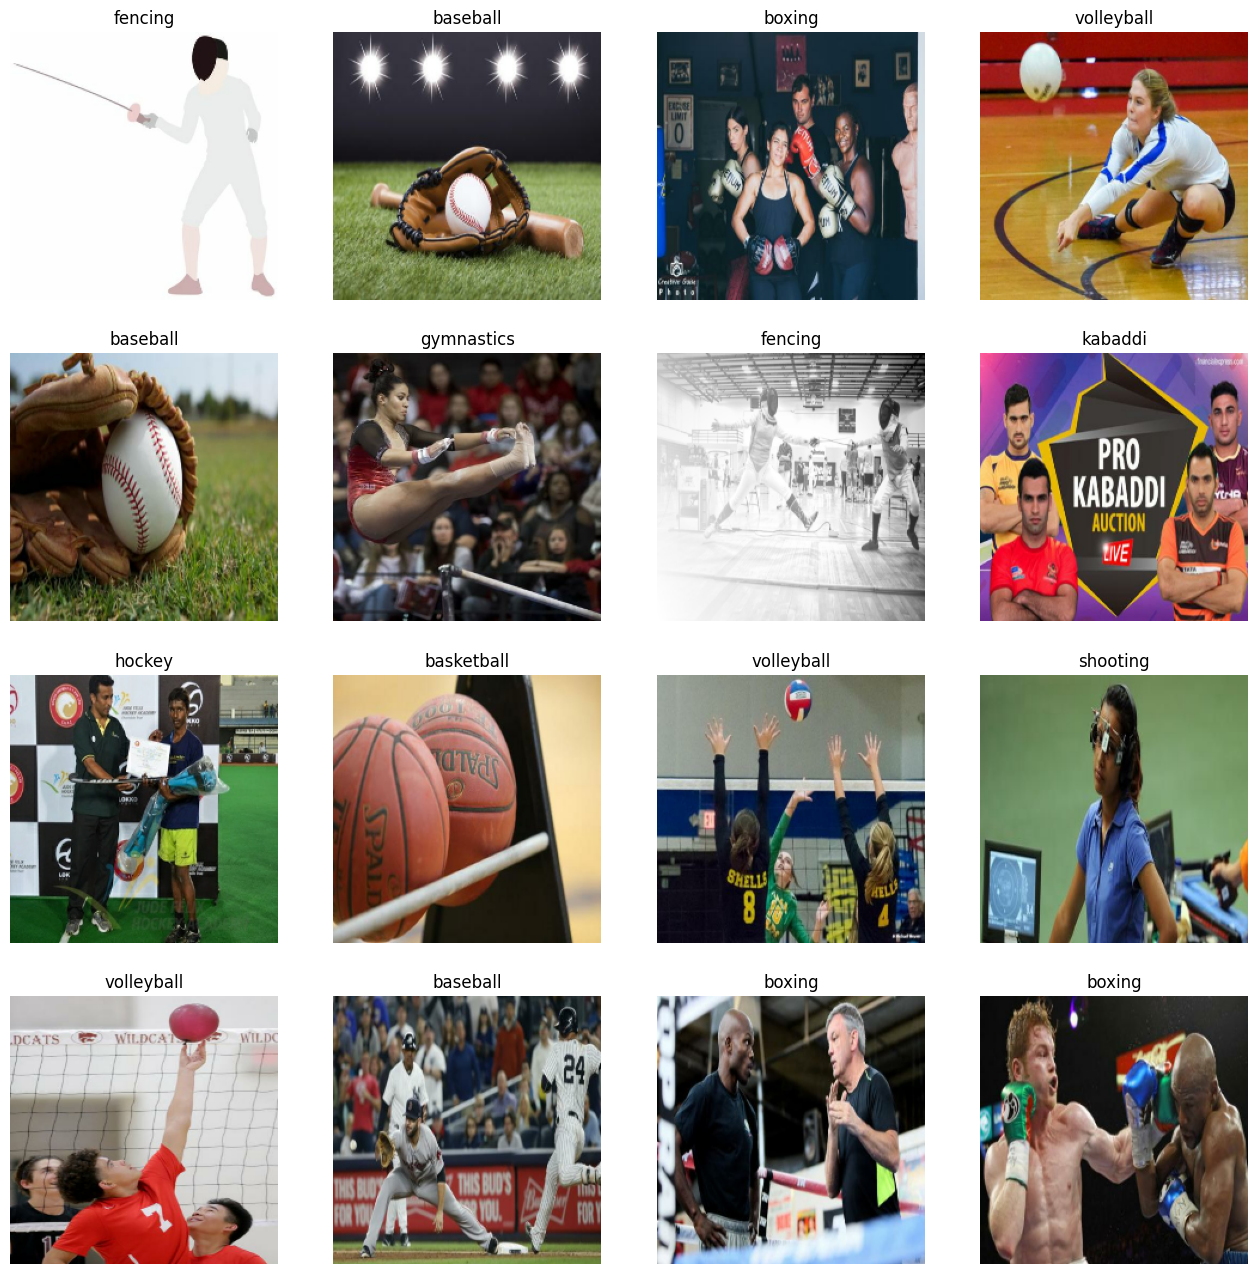

In [ ]:
# Show image function 
def show_images(dataset):
  plt.figure(figsize=(16,16))
  for images, labels in dataset.take(1):
    for i in range(16):
      ax = plt.subplot(4, 4, i + 1)
      ax.imshow(images[i].numpy().astype("uint8"))
      ax.set_title(dataset.class_names[labels[i]])
      ax.axis("off")
  plt.show()

show_images(dataset)

# 3. Backbone - Inception-ResNet-v2

- Overview:<br>
Inception-ResNet-v2 is a convolutional neural architecture that builds on the Inception family of architectures, but incorporates residual connections (replacing the filter concatenation stage of the Inception architecture).
<br>
This network is considerably deeper than the previous Inception V3. The residual versions of the Inception networks use cheaper Inception blocks than the original Inception.
Each Inception block is followed by filter-expansion layer (1 × 1 convolution without activation) which is used for scaling up the dimensionality of the filter bank before the addition to match the depth of the input.
- Architecture:
<img src="https://i.ibb.co/cQzDFVj/Inception-Resnet-v2-drawio.jpg" alt="Backbone" border="0">
Convolutions not marked with “V” in the above figures are same-padded meaning that their output grid matches the size of their input. While convolutions marked with “V” are valid padded, meaning that size of the output activation map is reduced. <br>
Figure 1 above represents the architecture of Inception-ResNet-v2 networks, which consists of:
  
  + The stem represented in Figure 2 is the beginning of the network, receives input rgb images of size 299x299x3.
  + 5 x Inception-ResNet-A (Figure 3), 10 x Inception-ResNet-B (Figure 5) and 5 x Inception-ResNet-C (Figure 7) blocks. Each kind of blocks is an image model block that follows the idea of Inception modules - and grouped convolutions - but also includes residual connections.
  + 2 reduction blocks, Reduction-A (Figure 4) and Reduction-B (Figure 6). They are interspersed with the Inception-ResNet blocks to reduce the size of feature maps.
  + After these blocks, we have some basic layers are Average Pooling layer, Dropout layer and Softmax function at last for the ouput probabilities.
  
- Training Methodology

The model was trained with stochastic gradient utilizing the TensorFlow distributed machine learning system using 20 replicas running each on a NVidia Kepler GPU. The training process uses RMSProp with decay of 0.9 and ϵ = 1.0, learning rate of 0.045, decayed every two epochs using an exponential rate of 0.94. Model evaluations are performed using a running average of the parameters computed over time.

- Results from the Paper:

<img src="https://i.ibb.co/5cqLmLR/image.png" alt="Backbone" border="0">

## 3.1. Define utilities and select a backbone

In these *feature_extractor, preprocess_methods, input_sizes* dictionaries we can add more backbone later, the same way with adding **InceptionResNetV2**

In [ ]:
feature_extractor = {
    "VGG16": VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet'),
    "ResNet50": ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet'),
    "NASNetLarge": NASNetLarge(include_top=False, input_shape=(299, 299, 3), weights='imagenet'),
    "InceptionResNetV2": InceptionResNetV2(include_top=False, input_shape=(299, 299, 3), weights='imagenet')
}

preprocess_methods = {
    "VGG16": app.vgg16.preprocess_input,
    "ResNet50": app.resnet50.preprocess_input,
    "NASNetLarge": app.nasnet.preprocess_input,
    "InceptionResNetV2": app.inception_resnet_v2.preprocess_input
}

input_sizes = {
    "VGG16": (224, 224),
    "ResNet50": (224, 224),
    "NASNetLarge": (299, 299),
    "InceptionResNetV2": (299, 299)
}

343610240/343610240 [==============================] - 2s 0us/step


In [ ]:
#################################################################################
## Specify the backbone that will be used in the following cells
#################################################################################
backbone = "InceptionResNetV2"
batch_size = 32

## 3.2. Visualize feature maps from pre-trained model

### 3.2.1. Implement models to extract feature maps

In [ ]:
model = feature_extractor[backbone]

# redefine model to extract feature maps from output of 3 choosen layers
output_idx = [1, 10, 30]
outputs = [model.layers[i].output for i in output_idx]
model = Model(inputs=model.inputs, outputs=outputs)

Use 1 random image to demonstrate

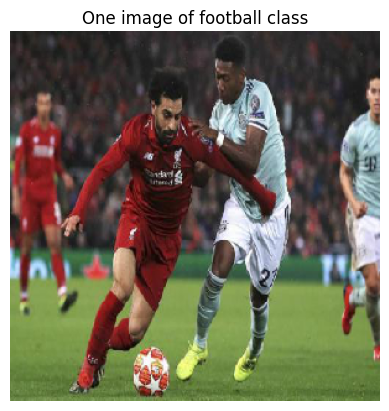

In [ ]:
# helper function to show image
def show_image(img, title):
  plt.figure()
  plt.imshow(img)
  plt.axis("off")
  plt.title(title)
  plt.show()

img_path = '/content/sports/Sports-Type-Classifier-master/data/football/00000030.jpg' 
img = load_img(img_path, target_size=input_sizes[backbone])

show_image(img, "One image of football class")

In [ ]:
# preprocess image for model
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_methods[backbone](img)

# get feature maps
feature_maps = model.predict(img)

1/1 [==============================] - 9s 9s/step


### 3.2.2. Visualize feature maps

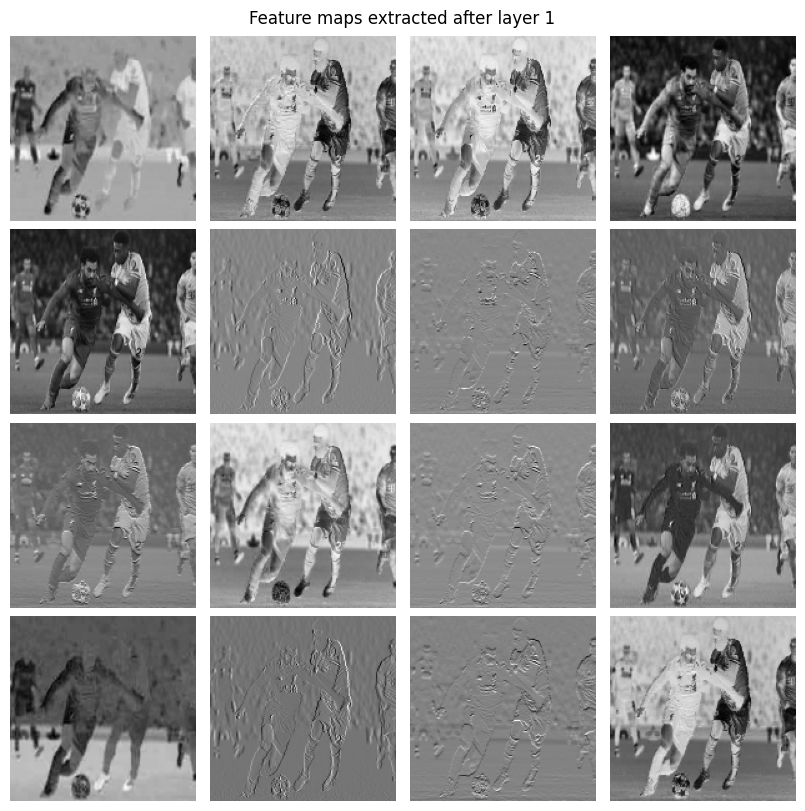

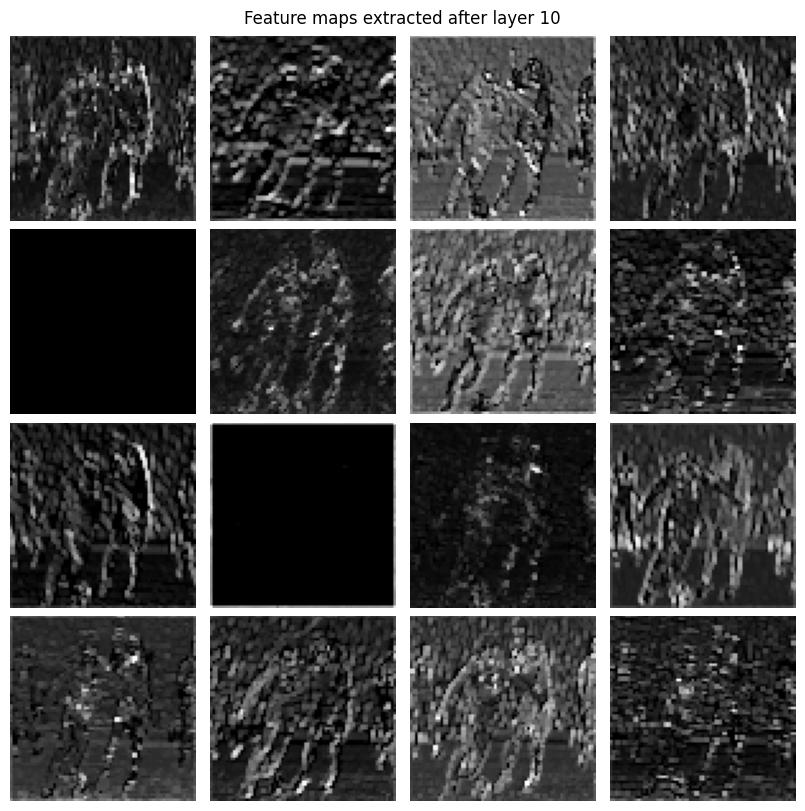

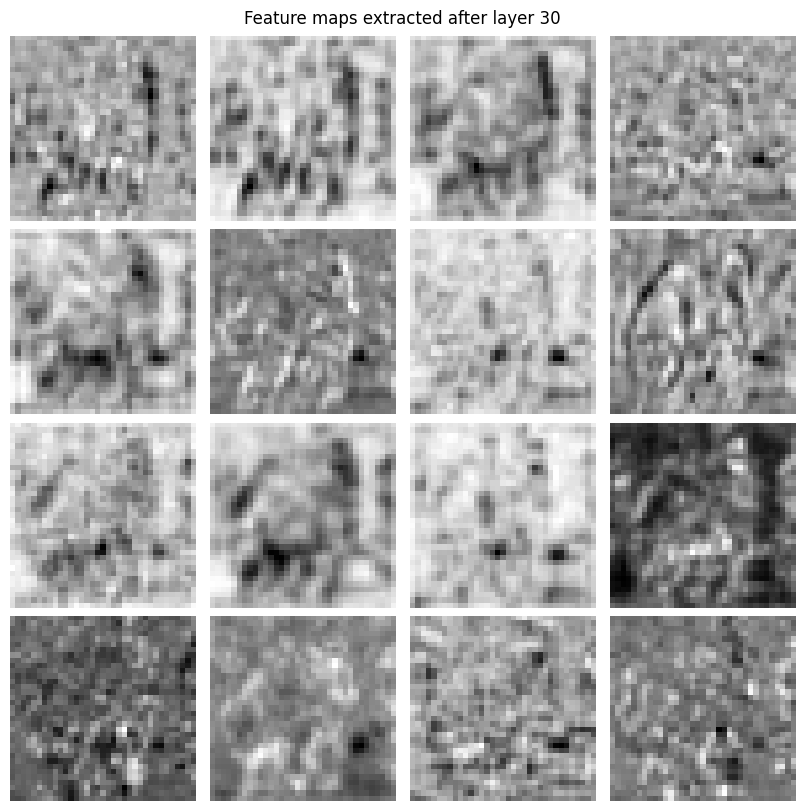

In [ ]:
square = 4
num_block = 0

for fmap in feature_maps:
  # plot 16 images for each feature map
  fig = plt.figure(figsize=(8,8),  layout='constrained')
  for idx in range(square*square):
      ax = plt.subplot(square, square, idx + 1)
      ax.imshow(fmap[0, :, :, idx-1], cmap='gray')
      ax.axis('off')

  fig.suptitle("Feature maps extracted after layer {}".format(output_idx[num_block]))
  plt.show()
  num_block += 1

### 3.2.3. Compare the output feature map of blocks
> With the above results, we have the following evaluations


+ In the feature map extracted after layer 1 (low-level layer), the feature map is quite similar to the input image and we can still see the information from the image.
+ In feature maps extracted after layer 10, feature maps become less recognizable, although they are still somewhat similar to the original image.
+ Finally, in the feature map extracted after layer 30 (high-level layer), the image has now become unregconized. Feature maps now focus on extracting certain features of the image, which not all images have.

> As we go deeper into the network, the feature maps look less like the original image and more like an abstract representation of it. The reason is that deeper feature maps encode high level information while lower level feature maps detect simple edges and shapes. That's why deeper feature maps contain less information about the image and more about the class of the image.



## 3.3. Create a train and a validation test



In [ ]:
generator = ImageDataGenerator(
    horizontal_flip=True, 
    vertical_flip=True, 
    rotation_range=20, 
    fill_mode="nearest",
    validation_split=0.2,
    preprocessing_function=preprocess_methods[backbone]
    )

train_set = generator.flow_from_directory(
    path_to_data, 
    target_size=input_sizes[backbone], 
    class_mode='categorical', 
    batch_size= batch_size, 
    shuffle=True, 
    subset='training')

valid_set = generator.flow_from_directory(
    path_to_data, 
    target_size=input_sizes[backbone], 
    class_mode='categorical', 
    batch_size= batch_size, 
    shuffle=True, 
    subset='validation')

Found 11496 images belonging to 22 classes.
Found 2863 images belonging to 22 classes.


In [ ]:
train_set.class_indices

{'badminton': 0,
 'baseball': 1,
 'basketball': 2,
 'boxing': 3,
 'chess': 4,
 'cricket': 5,
 'fencing': 6,
 'football': 7,
 'formula1': 8,
 'gymnastics': 9,
 'hockey': 10,
 'ice_hockey': 11,
 'kabaddi': 12,
 'motogp': 13,
 'shooting': 14,
 'swimming': 15,
 'table_tennis': 16,
 'tennis': 17,
 'volleyball': 18,
 'weight_lifting': 19,
 'wrestling': 20,
 'wwe': 21}

# 4. Defining prediction model

## 4.1. Create, train on new model (Run this section if you want to create new model with dense, then do the training process, else you can run from 4.2 to save your time)

### 4.1.1. Create the model architecture



In [ ]:
def create_model(backbone):
  fextractor = feature_extractor[backbone]
  fextractor.trainable = False 

  model = keras.Sequential([
      fextractor,
      GAP(),
      Dense(num_classes, activation='softmax')
  ], name=backbone)
  return model

model = create_model(backbone)
model.summary()


Model: "InceptionResNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 22)                33814     
                                                                 
Total params: 54,370,550
Trainable params: 33,814
Non-trainable params: 54,336,736
_________________________________________________________________


### 4.1.2. Train and save the created model 

In [ ]:
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5,
    decay_rate=0.95,
    staircase=True)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule)

# def top_5_categorical_accuracy(y_true, y_pred):
#   return top_k_categorical_accuracy(y_true, y_pred, k=5)

# def top_11_categorical_accuracy(y_true, y_pred):
#   return top_k_categorical_accuracy(y_true, y_pred, k=11)

model.compile(
     loss='categorical_crossentropy',
     optimizer=optimizer,
     metrics=['accuracy', TopKCategoricalAccuracy(k=5)]
 )

# Callbacks 
cbs = [
     EarlyStopping(patience=3, restore_best_weights=True),
     ModelCheckpoint(backbone + ".h5", save_best_only=True)
 ]




In [ ]:
# Train Model
history = model.fit(
     train_set, validation_data=valid_set,
     callbacks=cbs,
     epochs=15, 
     verbose=2
)

In [ ]:
# list all data in history
print("Training History:")
print(history.history.keys())

# summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

### 4.1.3. Load and evalute the trained model

In [ ]:
model_file = "./{:s}.h5".format(backbone)
trained_model = load_model(model_file)
# trained_model.evaluate(valid_set)

90/90 [==============================] - 73s 775ms/step - loss: 1.3124 - accuracy: 0.8477 - top_k_categorical_accuracy: 0.9696


[1.312376618385315, 0.8477122187614441, 0.9696123003959656]

## 4.2. Load trained model that we put on Kaggle (Comment the code below to use new trained model, otherwise this cell will use the trained InceptionResNetV2 that we put on kaggle)

In [ ]:
trained_model = load_model("./trained_models/InceptionResNetV2.h5")


## 4.3. Load other trained models and compare

In [ ]:
def create_compare_data(model_name):
  test_generator = ImageDataGenerator(
      preprocessing_function=preprocess_methods[model_name]
      )

  test_set = test_generator.flow_from_directory(
      path_to_data, # Assume that this is test-set
      target_size=input_sizes[model_name], 
      class_mode='categorical', 
      batch_size= batch_size,
      shuffle = False)
  return test_set

In [ ]:
# Create dictionary to store data
# evaluate_res = trained_model.evaluate(valid_set)
res = {}
res["InceptionResNetV2"] = trained_model.evaluate(create_compare_data("InceptionResNetV2"))

Found 14359 images belonging to 22 classes.
449/449 [==============================] - 146s 325ms/step - loss: 1.2142 - accuracy: 0.8661 - top_k_categorical_accuracy: 0.9765


In [ ]:
models = ["NASNetLarge", "ResNet50", "VGG16"]
for model in models:
  kaggle_trained_model = load_model("./trained_models/{}.h5".format(model))
  res[model] = kaggle_trained_model.evaluate(create_compare_data(model))

Found 14359 images belonging to 22 classes.
449/449 [==============================] - 342s 748ms/step - loss: 2.0442 - accuracy: 0.8820 - top_k_categorical_accuracy: 0.9773
Found 14359 images belonging to 22 classes.
449/449 [==============================] - 90s 190ms/step - loss: 2.8559 - accuracy: 0.8674 - top_k_categorical_accuracy: 0.9798
Found 14359 images belonging to 22 classes.
449/449 [==============================] - 93s 198ms/step - loss: 5.4223 - accuracy: 0.8164 - top_k_categorical_accuracy: 0.9691


In [ ]:
df = pd.DataFrame.from_dict(res)

In [ ]:
df.index = ["Loss", "Top-1-accuracy", "Top-5-accuracy"]
df

InceptionResNetV2  NASNetLarge  ResNet50     VGG16
Loss                     1.214244     2.044166  2.855925  5.422329
Top-1-accuracy           0.866077     0.882025  0.867400  0.816352
Top-5-accuracy           0.976461     0.977296  0.979804  0.969148

Can see that, our model have good performance over VGG16 and approximate with ResNet50. about NASNetLarge, which is very big model so that it can out performance with ours

Confusion Matrix

Found 14359 images belonging to 22 classes.
449/449 [==============================] - 149s 333ms/step
Confusion Matrix


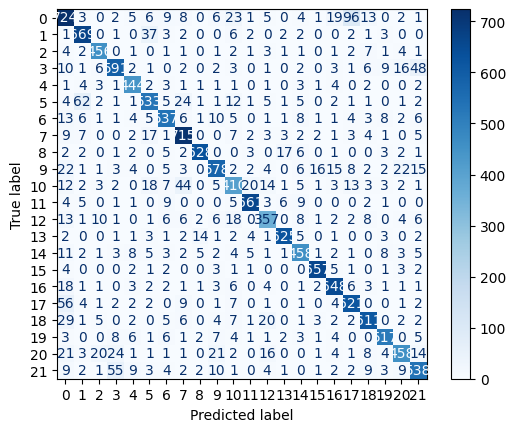

0
badminton        0
baseball         1
basketball       2
boxing           3
chess            4
cricket          5
fencing          6
football         7
formula1         8
gymnastics       9
hockey          10
ice_hockey      11
kabaddi         12
motogp          13
shooting        14
swimming        15
table_tennis    16
tennis          17
volleyball      18
weight_lifting  19
wrestling       20
wwe             21

In [ ]:
# Print Confusion matrix
def cfs_matrix(y_pred, data_generator):
  print('Confusion Matrix')
  cm = (confusion_matrix(data_generator.classes, y_pred))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(data_generator.class_indices.values()))
  disp.plot(cmap=plt.cm.Blues)
  plt.show()


test_set = create_compare_data("InceptionResNetV2")
Y_pred = trained_model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)

cfs_matrix(y_pred, test_set)

temp = test_set.class_indices.copy()
for e in temp:
  temp[e] = [temp[e]]
df = pd.DataFrame.from_dict(temp).T
df

Classification Report

In [ ]:
def report(y_pred, data_generator):
  print('Classification Report')
  target_names = list(data_generator.class_indices.keys())
  print(classification_report(data_generator.classes, y_pred, target_names=target_names))
  return classification_report(data_generator.classes, y_pred, target_names=target_names, output_dict=True)

cls_report = report(y_pred, test_set)

Classification Report
                precision    recall  f1-score   support

     badminton       0.74      0.78      0.76       928
      baseball       0.86      0.92      0.89       731
    basketball       0.89      0.93      0.91       490
        boxing       0.85      0.84      0.84       704
         chess       0.89      0.93      0.91       475
       cricket       0.84      0.80      0.82       665
       fencing       0.87      0.86      0.87       624
      football       0.85      0.91      0.88       784
      formula1       0.96      0.93      0.94       675
    gymnastics       0.87      0.81      0.84       711
        hockey       0.78      0.72      0.75       569
    ice_hockey       0.94      0.93      0.94       707
       kabaddi       0.80      0.79      0.80       452
        motogp       0.95      0.94      0.94       668
      shooting       0.86      0.86      0.86       531
      swimming       0.95      0.96      0.96       683
  table_tennis       0.90

# 5. Predicting and showing the result for some images

## 5.1. Load test-set

In [ ]:
test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_methods[backbone]
    )

test_set = test_generator.flow_from_directory(
    path_to_data, # Assume that this is test-set
    target_size=input_sizes[backbone], 
    class_mode='categorical', 
    batch_size= batch_size)

Found 14359 images belonging to 22 classes.


## 5.2 Predict images in a batch and show the results

In [ ]:
trained_model.evaluate(test_set)

449/449 [==============================] - 144s 320ms/step - loss: 1.2142 - accuracy: 0.8661 - top_k_categorical_accuracy: 0.9765


[1.2142431735992432, 0.8660770058631897, 0.9764607548713684]

float32 -1.0 1.0
1/1 [==============================] - 3s 3s/step


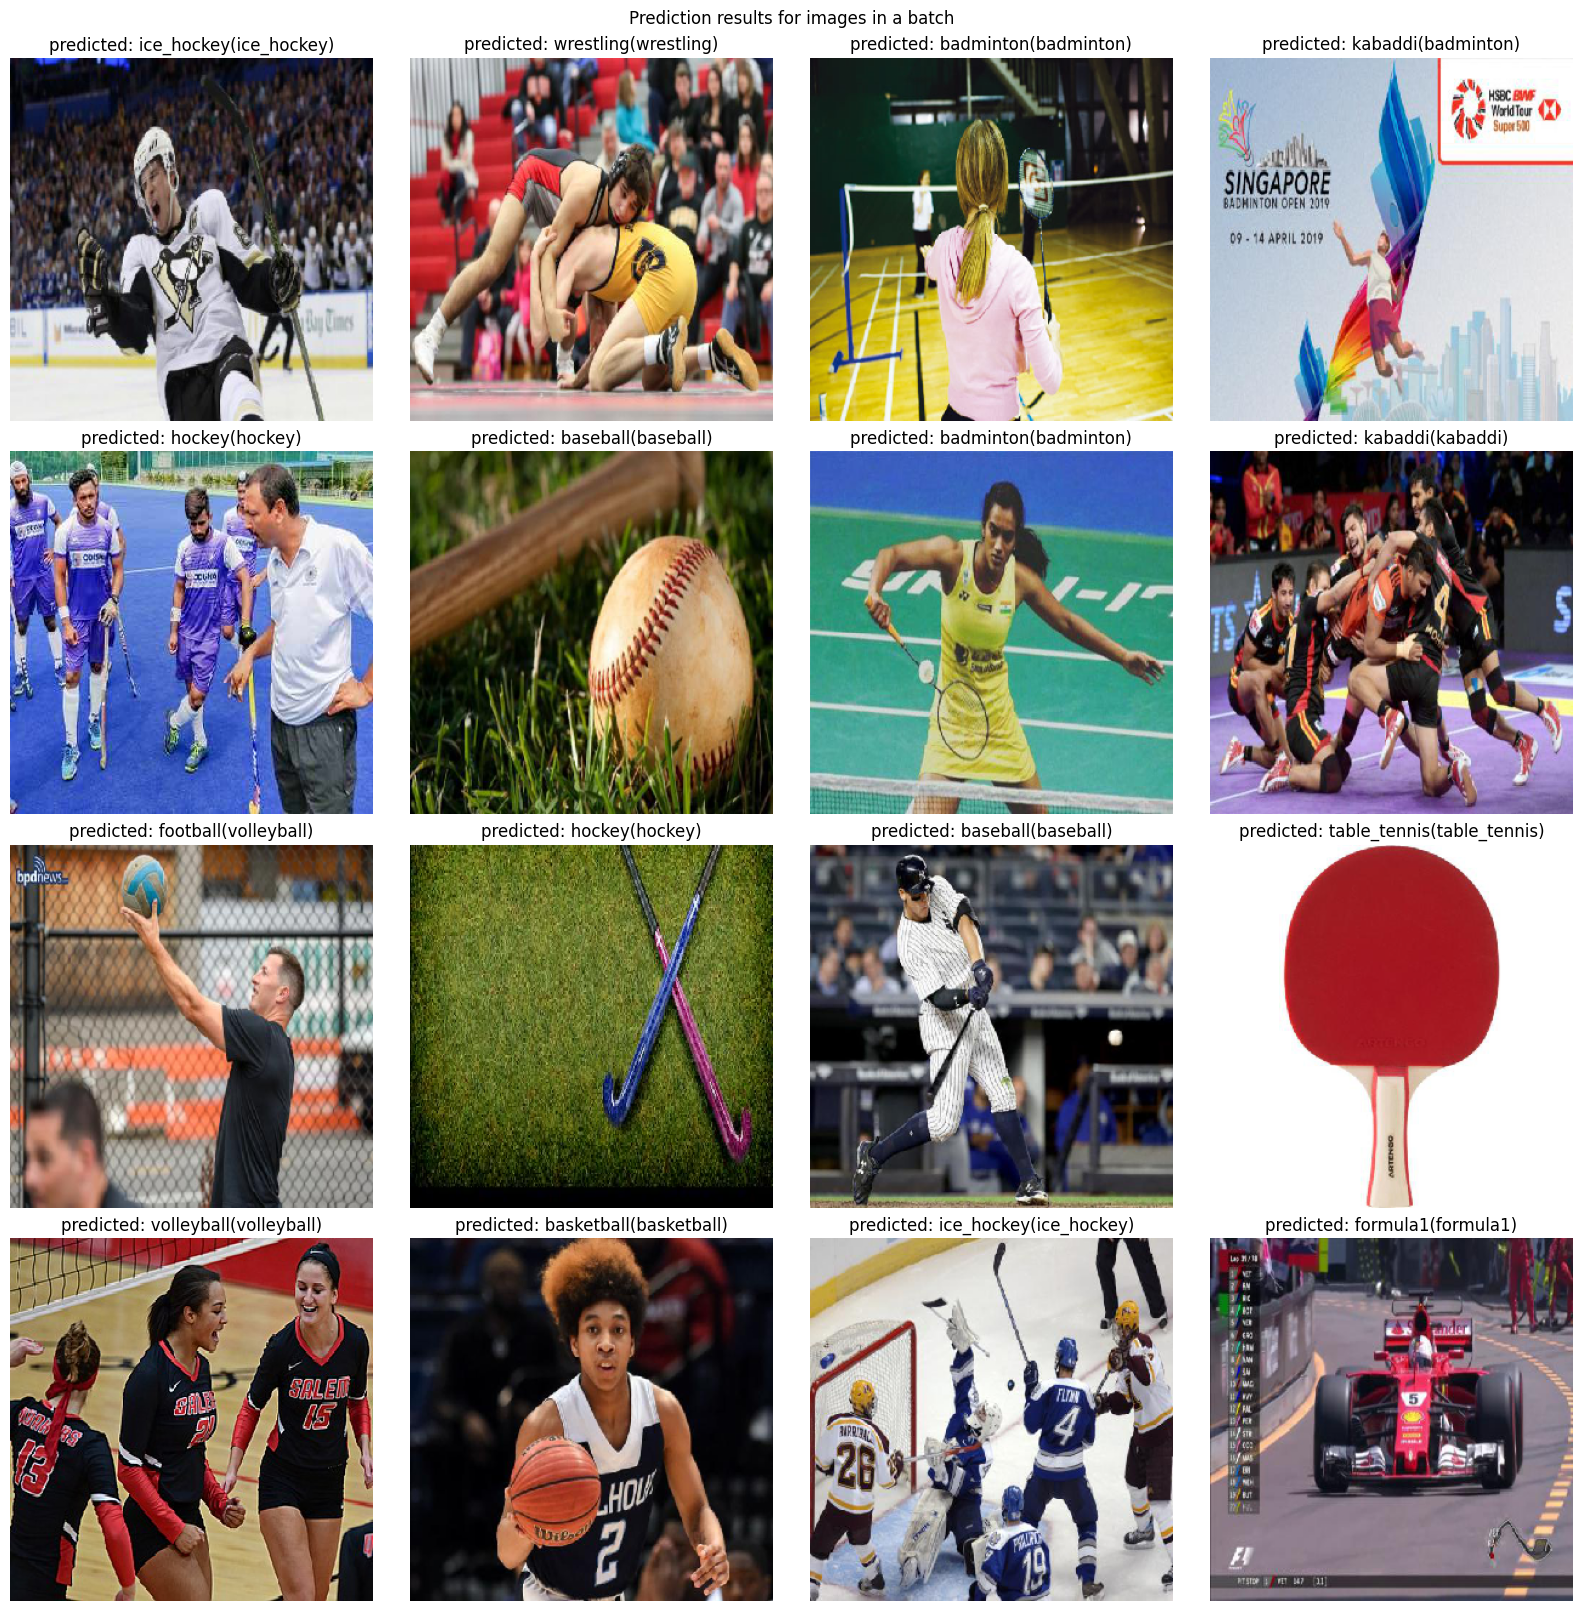

In [ ]:
def show_prediction(dataset, model, backbone):
  for images, labels in dataset:
    print(images.dtype, images.min(), images.max())
    probs = model.predict(images)

    pred_labels = probs.argmax(axis=-1)
    pred_labels = [class_names[idx] for idx in pred_labels]
    ori_labels = [class_names[int(list(label).index(1))] for label in labels]

    fig = plt.figure(figsize=(16,16), layout='constrained')
    for i in range(16):
      ax = plt.subplot(4, 4, i + 1)
      image  = ((images[i] + 1) / 2).astype(np.float32)
      ax.imshow(image)
      title = "predicted: {:s}({:s})".format(pred_labels[i], ori_labels[i])
      ax.set_title(title)
      ax.axis("off")
    fig.suptitle("Prediction results for images in a batch")
    plt.show()
    break

show_prediction(test_set, trained_model, backbone)

# 6. Evaluate Results 

- From the predict result above, we can assume that predict result from our model have a good performance on the dataset that we used to train. Besides the usual metric for evaluate model is accuracy, we also use a metric called top "k" categorical accuracy. Top k means that the true label is in classes with k biggest probabilities predicted from the model. Using k=5, our model has the top 5 accuracy is 97.55%, while the original accuracy (a.k.a top 1 accuracy) is 86.47% for test set. 

- The model still has some mistakes when predict the *wwe* or *boxing* or *wrestling* or *gymnastics*, *hockey* vs *ice_hockey*, *football* or *cricket*.

- Because our dataset is big (about 14000 images), but not big enough with 22 classes, so the predicted results cannot be very good. Though there are augmentation techniques using ImageDataGenerator module for our dataset, the results are still not as good as expected. Therefore, to have good enough data to fit the model, we will have to improve our augmentation technique or even collect more images for the dataset.